### 1. 安装HuggingFace 并下载模型到本地

In [58]:
#!pip install huggingface-hub -Uqq -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install modelscope -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install -U sagemaker==2.235.2 -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install tiktoken  -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install boto3==1.34.101  -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 688.4 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.235.1
    Uninstalling sagemaker-2.235.1:
      Successfully uninstalled sagemaker-2.235.1
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/b2/f3/9b7428cc79611044f6db5f8ea1113f6d0a04a7a236e9cc0642107494839a/boto3-1.34.101-py3-none-any.whl (139 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/bc/47/e35f788047c91110f48703a6254e5c84e33111b3291f7b57a653ca00accf/botocore-1.34.162-py3-none-any.whl (12.5 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.67
    Uninstalling botocore-1.35.67:
      Successfully uninstalled botocore-1.3

In [1]:
!rm -rf ./LLM_qwen_25_int8_model

## 如果是海外区域，可以直接从HF下载

In [ ]:
#from huggingface_hub import snapshot_download
#from pathlib import Path
#local_model_path = Path("./LLM_qwen_int4_model")
#local_model_path.mkdir(exist_ok=True)

In [ ]:
# model_name = "Qwen/Qwen-7B-Chat-Int4"
# commit_hash = "b725fe596dce755fe717c5b15e5c8243d5474f66"

In [ ]:
# snapshot_download(repo_id=model_name, revision=commit_hash, cache_dir=local_model_path)

## 如果是中国区，从modelscope下载比较快

In [3]:
from modelscope.hub.snapshot_download import snapshot_download
from pathlib import Path

local_model_path = Path("./LLM_qwen_25_int8_model")
#local_model_path = Path("./LLM_qwen_25_int4_model")
local_model_path.mkdir(exist_ok=True)
#model_name = "Qwen/Qwen2.5-14B-Instruct-GPTQ-Int4"
model_name = "Qwen/Qwen2.5-14B-Instruct-GPTQ-Int8"
# commit_hash = "v1.1.4"
commit_hash = "master"

snapshot_download(model_name, revision=commit_hash, cache_dir=local_model_path)


### 2. 把模型拷贝到S3为后续部署做准备

In [13]:
import sagemaker
from sagemaker import Model, image_uris, serializers, deserializers
import boto3
import os
import time
import json
#from sagemaker.djl_inference.model import DJLModel

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")
as_client = boto3.client("application-autoscaling")

In [5]:
s3_model_prefix = "LLM-RAG/workshop/LLM_qwen_25_int8_stream_model"  # folder where model checkpoint will go
#s3_model_prefix = "LLM-RAG/workshop/LLM_qwen_25_int4_stream_model"
model_snapshot_path = list(local_model_path.glob("**/Qwen/*"))[0]
#s3_code_prefix = "LLM-RAG/workshop/LLM_qwen_25_int4_stream_deploy_code_bak"
s3_code_prefix = "LLM-RAG/workshop/LLM_qwen_25_int8_stream_deploy_code_bak"
print(f"s3_code_prefix: {s3_code_prefix}")
print(f"model_snapshot_path: {model_snapshot_path}")

s3_code_prefix: LLM-RAG/workshop/LLM_qwen_25_int8_stream_deploy_code_bak
model_snapshot_path: LLM_qwen_25_int8_model/Qwen/Qwen2___5-14B-Instruct-GPTQ-Int8


In [6]:
#把Notebook本地缓存的模型文件拷贝到S3
!aws s3 cp --recursive {model_snapshot_path} s3://{bucket}/{s3_model_prefix}
s3_path = f"s3://{bucket}/{s3_model_prefix}/"
print(f"option.s3url ==> {s3_path}")

option.s3url ==> s3://sagemaker-cn-northwest-1-994626867605/LLM-RAG/workshop/LLM_qwen_25_int8_stream_model/


### 3. 模型部署准备（entrypoint脚本，容器镜像，服务配置）

In [7]:
# 中国区需要替换为下面的image_uri，通过DJL框架支持http的endpoint接口、弹性扩展以及高性能高吞吐的推理服务。
# 通过deepspeed深度学习框架提供了模型并行化的能力，可以通过多GPU解决长Prompt推理显存溢出的问题以及模型超过单GPU显存不足无法部署的问题
#inference_image_uri = (
#    f"727897471807.dkr.ecr.{region}.amazonaws.com.cn/djl-inference:0.29.0-lmi11.0.0-cu124"
#)

#inference_image_uri = (
#    f"727897471807.dkr.ecr.{region}.amazonaws.com.cn/djl-inference:0.27.0-deepspeed0.12.6-cu121"
#)

inference_image_uri = image_uris.retrieve(
    framework="djl-lmi",
    region=sess.boto_session.region_name,
     version="0.29.0"
)
print(f"Image going to be used is ---- > {inference_image_uri}")

[11/28/24 04:24:24] INFO     Ignoring unnecessary instance type: None.                            ]8;id=110265;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=816797;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

Image going to be used is ---- > 727897471807.dkr.ecr.cn-northwest-1.amazonaws.com.cn/djl-inference:0.29.0-lmi11.0.0-cu124


In [101]:
#!mkdir -p LLM_qwen_25_int8_stream_deploy_code_bak
!mkdir -p LLM_qwen_25_int4_stream_deploy_code_bak

In [165]:
%%writefile LLM_qwen_25_int4_stream_deploy_code_bak/serving.properties
#%%writefile LLM_qwen_25_int8_stream_deploy_code_bak/serving.properties
engine=Python
#通过下面参数修改模型的Tensor并行度，从而控制模型可以部署到几块GPU卡
option.tensor_parallel_degree=1

option.rolling_batch=vllm
# Adjust the following based on model size and instance type
option.max_rolling_batch_size=32
option.max_model_len=4096
#option.tensor_parallel_degree=2
option.enable_streaming=True
option.predict_timeout=240
#option.predict_timeout=360
#option.trust_remote_code=true
#option.s3url = S3PATH
option.model_id = S3PATH
#当使用替换deepspeed后的djl-lmi框架的镜像时，如果serving.properties与config.json不再同一层级目录保存，必须使用option.model_id。如果使用option.s3url则会在模型部署时报错找不到config文件

Overwriting LLM_qwen_25_int4_stream_deploy_code_bak/serving.properties


In [166]:
!sed -i "s|option.model_id = S3PATH|option.model_id = {s3_path}|" LLM_qwen_25_int4_stream_deploy_code_bak/serving.properties
#!sed -i "s|option.model_id = S3PATH|option.model_id = {s3_path}|" LLM_qwen_25_int8_stream_deploy_code_bak/serving.properties

In [167]:
#存储推理代码并打包成模型文件
!rm model.tar.gz
#!cd LLM_qwen_25_int8_stream_deploy_code_bak && rm -rf ".ipynb_checkpoints"
!cd LLM_qwen_25_int4_stream_deploy_code_bak && rm -rf ".ipynb_checkpoints"
#!tar czvf model.tar.gz LLM_qwen_25_int8_stream_deploy_code_bak
!tar czvf model.tar.gz LLM_qwen_25_int4_stream_deploy_code_bak

LLM_qwen_25_int4_stream_deploy_code_bak/
LLM_qwen_25_int4_stream_deploy_code_bak/serving.properties


In [168]:
#上传模型文件到S3
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-cn-northwest-1-994626867605/LLM-RAG/workshop/LLM_qwen_25_int8_stream_deploy_code_bak/model.tar.gz


### 4. 创建模型 & 创建endpoint

In [187]:
#Sagemaker中创建模型
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base(f"qwen-25-14B-stream-int4") #Note: Need to specify model_name
#model_name = name_from_base(f"qwen-25-14B-stream-int8")
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

qwen-25-14B-stream-int4-2024-12-05-12-33-16-061
Image going to be used is ---- > 727897471807.dkr.ecr.cn-northwest-1.amazonaws.com.cn/djl-inference:0.29.0-lmi11.0.0-cu124
Created Model: arn:aws-cn:sagemaker:cn-northwest-1:994626867605:model/qwen-25-14B-stream-int4-2024-12-05-12-33-16-061


In [188]:
#Sagemaker中创建模型端点配置文件
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"
variant_name = f"{model_name}-variant"

#Note: ml.g4dn.2xlarge 也可以选择
endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": variant_name,
            "ModelName": model_name,
            #"InstanceType": "ml.g4dn.12xlarge",
            #"InstanceType": "ml.g4dn.2xlarge",
            "InstanceType": "ml.g5.2xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 15*60,
        },
    ],
)



In [189]:
#创建Sagemaker endpoint
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws-cn:sagemaker:cn-northwest-1:994626867605:endpoint/qwen-25-14B-stream-int4-2024-12-05-12-33-16-061-endpoint


In [190]:
import time
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws-cn:sagemaker:cn-northwest-1:994626867605:endpoint/qwen-25-14B-stream-int4-2024-12-05-12-33-16-061-endpoint
Status: InService


In [191]:
print(resp["EndpointName"])

qwen-25-14B-stream-int4-2024-12-05-12-33-16-061-endpoint


In [174]:
#endpoint创建成功后创建AS的伸缩规则
import pprint
pp = pprint.PrettyPrinter(indent=4, depth=4)
response = sm_client.describe_endpoint(EndpointName=endpoint_name)
pp.pprint(response)

#此处务必使用创建endpoint config时指定的product variant name
resource_id = 'endpoint/' + endpoint_name + '/variant/' + variant_name

#在AS中注册一个sagemaker使用的扩展目标
response = as_client.register_scalable_target(
    ServiceNamespace='sagemaker', 
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=2
)

#配置扩展策略 - SageMakerVariantInvocationsPerInstance Metric
response = as_client.put_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker', # The namespace of the AWS service that provides the resource. 
    ResourceId=resource_id, # Endpoint name 
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
    PolicyType='TargetTrackingScaling', # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 5, # The target value for the metric. - here the metric is - SageMakerVariantInvocationsPerInstance
        'PredefinedMetricSpecification': {
            #'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance', # is the average number of times per minute that each instance for a variant is invoked. 
            #收集1分钟内的指标
            'PredefinedMetricType': 'SageMakerVariantConcurrentRequestsPerModelHighResolution',
        },
        'ScaleInCooldown': 600, # The cooldown period helps you prevent your Auto Scaling group from launching or terminating 
                                # additional instances before the effects of previous activities are visible. 
                                # You can configure the length of time based on your instance startup time or other application needs.
                                # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start. 
        'ScaleOutCooldown': 300 # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled. 
                            # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    }
)

{   'CreationTime': datetime.datetime(2024, 12, 4, 13, 18, 45, 123000, tzinfo=tzlocal()),
    'EndpointArn': 'arn:aws-cn:sagemaker:cn-northwest-1:994626867605:endpoint/qwen-25-14B-stream-int4-2024-12-04-13-18-40-251-endpoint',
    'EndpointConfigName': 'qwen-25-14B-stream-int4-2024-12-04-13-18-40-251-config',
    'EndpointName': 'qwen-25-14B-stream-int4-2024-12-04-13-18-40-251-endpoint',
    'EndpointStatus': 'InService',
    'LastModifiedTime': datetime.datetime(2024, 12, 4, 13, 26, 23, 855000, tzinfo=tzlocal()),
    'ProductionVariants': [   {   'CurrentInstanceCount': 1,
                                  'CurrentWeight': 1.0,
                                  'DeployedImages': [{...}],
                                  'DesiredInstanceCount': 1,
                                  'DesiredWeight': 1.0,
                                  'VariantName': 'qwen-25-14B-stream-int4-2024-12-04-13-18-40-251-variant'}],
    'ResponseMetadata': {   'HTTPHeaders': {   'content-length': '889',
   

In [175]:
#查询当前的扩展策略
response = as_client.describe_scaling_policies(
    ServiceNamespace='sagemaker'
)

for i in response['ScalingPolicies']:
    print('')
    pp.pprint(i['PolicyName'])
    print('')
    if('TargetTrackingScalingPolicyConfiguration' in i):
        pp.pprint(i['TargetTrackingScalingPolicyConfiguration']) 
    else:
        pp.pprint(i['StepScalingPolicyConfiguration'])
    print('')


'Invocations-ScalingPolicy'

{   'PredefinedMetricSpecification': {   'PredefinedMetricType': 'SageMakerVariantConcurrentRequestsPerModelHighResolution'},
    'ScaleInCooldown': 600,
    'ScaleOutCooldown': 300,
    'TargetValue': 5.0}



In [180]:
# 定义扩展目标的服务命名空间、资源ID和可扩展维度
service_namespace = 'sagemaker'
scalable_dimention = 'sagemaker:variant:DesiredInstanceCount'
# 删除扩展目标
response = as_client.deregister_scalable_target(
    ServiceNamespace=service_namespace,
    ResourceId=resource_id,
    ScalableDimension=scalable_dimention
)

# 打印响应
print(response)

{'ResponseMetadata': {'RequestId': '43889282-84dd-4c3d-9420-03d26503ffa3', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '43889282-84dd-4c3d-9420-03d26503ffa3', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'date': 'Wed, 04 Dec 2024 13:56:09 GMT'}, 'RetryAttempts': 0}}


### 5. 模型测试

## None stream - 逻辑问题测试endpoint状态

In [97]:
predictor = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

In [98]:
import time
#prompts1 = "写一首春天的诗"
prompts1 = """你现在是口袋奇兵(TopWar:Battle Game)的专属智能客服TopWarBot，你是一个非常专业的游戏客服，，请严格确理解的根据反引号中的资料提取相关信息，回答指挥官的各种问题，不可联想推测反引号中没有的信息,不可提供带有岐义和模棱两可的回答。
```
问题: 钛蓝金币转换成钻石的比例
回答: 按照1：1的比例i进行转换，1个钛蓝金币=1个钻石

问题: 金币
回答: 1、金币的定义：金币是《口袋奇兵》世界中的通用货币
2、金币的获得方法：在游戏内可以通过税收中心/金币收割机进行获取。需要放置金矿生产金币，同时有部分装饰是可以提高金币产量。税收中心只需要20个当前玩家等级民居即可达到之前造满民居的收益。新版本的金币自动收割机是需要10个当前等级的金矿。
3、金币的用途：建筑升级、装备制造与改造等大部分游戏功能均需要消耗一定数量的金币

问题: 远征行动中如何查看小地图与大地图
回答: 在远征行动主页面点击游戏正上方的小地图，可以查看当前关卡的信息，在点击右上角的“地图”就可以观看远征行动大地图信息

问题: 数值单位
回答: 游戏的数值显示单位为
k→m→b→t→aa→bb→cc→dd→ee→ff→gg→hh依次递进，1000进一个单位，比如1000=1k，1000k=1m，1000m=1b，1000b=1t，1000t=1aa，1000aa=1bb，1000bb=1cc。
```

指挥官: 金币单位t大还是b大
TopWarBot: 
"""

messages = [{"role":"user", "content": prompts1}]
# endpoint_name = 'qwen-stream-int4-2024-11-07-04-05-10-872-endpoint'
start = time.time()

response = predictor.predict({
    "messages": messages,
     "max_tokens":4096,
     "repetition_penalty": 1.05,
     "temperature": 0.7,
     "top_p": 0.8,
     "top_k": 20
    }
)
# text = str(response, "utf-8")
# print(response)
print(response["choices"][0]["message"]["content"])

#response_model = smr_client.invoke_endpoint(
#            EndpointName=endpoint_name,
#            Body=json.dumps(
#            {
#                "inputs" : prompts1,
#                "messages": messages,
#                "parameters": parameters
#            }
#            ),
#            ContentType="application/json",
#        )

#resp = response_model['Body'].read()
print (f"\ntime:{time.time()-start} s")
#print(resp.decode('utf8'))
# print(resp)

在游戏中，数值单位按照k→m→b→t→aa→bb→cc→dd→ee→ff→gg→hh的顺序递进，每个单位比前一个单位大1000倍。因此，t单位比b单位大，具体来说，1t等于1000b。

time:2.899348735809326 s


## 测试流式输出

In [132]:
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")

In [133]:
import io
import json


class MessageTokenIterator:
    def __init__(self, stream):
        self.byte_iterator = iter(stream)
        self.buffer = io.BytesIO()
        self.read_pos = 0

    def __iter__(self):
        return self

    def __next__(self):
        while True:
            self.buffer.seek(self.read_pos)
            line = self.buffer.readline()

            # print(line)
            if line and line[-1] == ord("\n"):
                self.read_pos += len(line)
                full_line = line[:-1].decode("utf-8")
                # print(full_line)
                line_data = json.loads(full_line.lstrip("data:").rstrip("/n"))
                return line_data["choices"][0]["delta"].get("content", "")
            chunk = next(self.byte_iterator)
            self.buffer.seek(0, io.SEEK_END)
            self.buffer.write(chunk["PayloadPart"]["Bytes"])
        
def get_realtime_response_stream(sagemaker_runtime, endpoint_name, payload):
    response_stream = sagemaker_runtime.invoke_endpoint_with_response_stream(
        EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType="application/json",
        CustomAttributes='accept_eula=false'
    )
    return response_stream

In [134]:
prompt = "世界上最高的山峰是哪座"
#messages = [
#    {"role": "system", "content": "You are a helpful assistant."},
#    {"role": "user", "content": prompt}
#]
messages = [
    {"role": "user", "content": prompt}
]
payload= {
    "messages": messages,
     "max_tokens":4096,
     "temperature": 0.7,
     "top_p": 0.8,
    "stream": "true"
    }

response_stream = get_realtime_response_stream(smr_client, endpoint_name, payload)
# print_response_stream(response_stream)
for token in MessageTokenIterator(response_stream["Body"]):
    # pass
    print(token, end="")

世界上最高的山峰是珠穆朗玛峰（也被称为珠峰或乔戈里峰），位于亚洲的喜马拉雅山脉，跨越尼泊尔和中国的边界。它的海拔高度为8,848米（29,029英尺）。

In [135]:
prompts = """
仅使用以下已知内容中列出的事实回答。
答案要从以下已知内容中提取，不能依赖任何先验知识。
已知内容:
""
已知信息1:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 Frequently Asked Questions 
& Case Pool
Table of Contents
关于录用Heathineers 员工 ………………………………………………………………………………………………
…..7............................................................................................................................................. 2
Interview and Assessment ...................................................................................................... 3
Should TA do rehire check for internal candidates for all internal transfer? TA 应该给所
有的内部转岗候选人做内部背景调查吗？ ............................................................................. 3
Application form里的第一个问题如何理解？ ......................................................................... 3
Offering and Onboarding ......................................................................................................... 3
Onboarding的时间有要求吗？............................................................................................... 3
What are the roles mandatory for Background Check? 哪些岗位是必须做背景核实的呢 ？
.................................................................................................................................................... 3
Hiring of Candidates who might have conflict of Interest in Companies by close 
relatives 雇用候选人-亲属存在公司利益冲突 ........................................................................ 3
What are the documents in P-File? P-File 当中应包含哪些文件？ ................................... 4
-.................................................................................................................................................. 5
员工推荐候选人到培训生岗位成功后，是否要付 ERP bonus？......................................... 5
Avature的 turndown offer 操作？.......................................................................................... 5
如果候选人来自EY怎么处理？.............................................................................................. 5
满足什么条件的员工可以 rehire？.......................................................................................... 6
对于Re-hire的候选人，之前在西门子的服务年限是否承认 ?.............................................. 6
关于non-solicitation obligation ................................................................................................. 7
We kindly ask you to refrain from contacting employees of any of the beforehand mentioned 
businesses concerning open positions in your units/countries. Please ensure that this 
regulation is known and obeyed within your organization globally. ........................................... 9
关于录用Heathineers 员工....................................................................................................... 9
GBS H2R员工推荐候选人成功，是否可以获得 ERP奖金？................................................... 9
Rehire check result 中如果离职原因显示‘ dismissed by low/poor performance’ ，还是否能录
用？............................................................................................................................................ 9
Offer候选人与原公司签署了竞业禁止协议，应该如何处理？ .......................................... 10
对于non-solicitation obligation ……………………………………………………………………………………………..6
    关于录用Heathineers 员工 ………………………………………………………………………………………………
…..7
GBS H2R员工推荐候选人成功，是否可以获得 ERP奖金？……………………………………………… ..8
Rehire check result 中如果离职原因显示‘ dismissed by low/poor performance’ ，还是否能录
用？…………………………………………………………………………………………………… .…………………………………..8
Offer Letter盖章选择和流程………………………………………………………… ..…………………………………..9
Sign On bonus……………………………………………………………………………………………………………………….9
Rehire员工是否Eligible for ERP Program ……………………………………………………………………………10
镇江西门子母线有限公司属于 Internal Transfer吗…………………………………………………………… 10
GRIP要怎么选？………………………………………………………………………………………………………………
….10
当hiring location和working location不在一个城市的情况下， fix allowance的标准是根据
hiring location还是working location来定? ………………………………………………………………………….11
新员工对于入职手续相关问题的咨询方式有哪些？……………………………………………………… .12
某位候选人之前在西门子工作过后离职，现在 rehire，是否还有试用期？………………… .12
新背调供应商CBI，使用指南………………… .………………….…….…………….…………….…………….……12


已知信息2:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息3:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息4:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息5:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息6:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息7:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息8:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息9:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息10:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息11:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息12:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
已知信息13:mx-prod-it-da-common/chatbot/dayu/files/P&O TA/P&O TA Public/92605267340839813||FAQ and Case Pool-2023.08.28.pdf:
 We kindly ask you to refrain from contacting employees of any of the beforehand mentioned businesses 
concerning open positions in your units/countries. Please ensure that this regulation is known and obeyed
within your organization globally.
关于录用Heathineers 员工
举例：Regarding the employee move between Siemens and Heathineers,    does it belong to 
cross-ARE transfer?
答：Yes, it belongs to cross
""
答案要从已知内容中提取，不能依赖任何先验知识。专业的回答用户的问题
问题: 关于录用healthineers员工有什么规定嘛\n
回答:
"""

In [136]:
#引入tiktoken用于后续计算context的token数量
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

In [137]:
#计算prompt的token数量
prompt = "".join([prompts])
token = encoding.encode(prompts)
print('context Token:', len(token))

context Token: 2744


## 串形多个请求提交

In [104]:

#运行多轮推理计算token产生的平局速度，包括产生1000个token的时间以及每秒产生的token时间
#start_time = time.time()

total_time = 0
total_tokens = 0
rounds = 2
messages = [
    {"role": "user", "content": prompts}
]
payload= {
    "messages": messages,
     "max_tokens":4096,
     "temperature": 0.7,
     "top_p": 0.8,
    "stream": "true"
    }

for _ in range(rounds):
    start = time.time()
    #sequence = generate_reponse(prompts1)
    token_len = 0
    response_stream = get_realtime_response_stream(smr_client, endpoint_name, payload)
    # print_response_stream(response_stream)
    for token in MessageTokenIterator(response_stream["Body"]):
    # pass
        
        print(token, end="")
        token_len += len(token)
    
    end = time.time()
    
    # print("\n")

    #token_len = 0
    #sequence = sequence.replace("<|endoftext|>","")
    #print(sequence, end='\n')
    # token = encoding.encode(sequence.replace("<|endoftext|>",""))
    #token = encoding.encode(sequence)

    #print('Generate Token:', len(token))
    print('Generate Token:', token_len)
    
    print('Time per 1K Token:', (end-start)*1024/token_len)
    print('Token per 1s:', token_len/(end-start))
    print("-"*100)
    total_time += (end-start)
    total_tokens += token_len

print('avg Token:',total_tokens/rounds)
print('avg Time per 1K Token:', (total_time)*1024/total_tokens)
print('avg Token per 1s:', total_tokens/(total_time))

关于录用Healthineers员工的规定如下：

- 关于员工从Siemens转移到Healthineers的情况，这被认定为跨ARE（Area of Responsibility）调动。
- 针对招聘流程，已明确要求组织内部应确保遵守不与之前提到的业务联系招聘岗位员工的规定。这意味着在贵单位/国家的任何开放职位上，不应联系之前提到业务的员工。请确保此规定在全球范围内被知晓并遵守。

以上信息来自提供的FAQ和案例池文档。Generate Token: 214
Time per 1K Token: 25.06453070239486
Token per 1s: 40.85454510034609
----------------------------------------------------------------------------------------------------
关于录用Healthineers员工的规定可以从已知内容中提取如下信息：

1. 关于录用Healthineers员工的移动问题，如果员工从Siemens移动到Healthineers，这被视为跨区域（cross-ARE）调动。
   
   举例：员工从Siemens调动到Healthineers是否属于跨区域调动？
   答：是的，这属于跨区域调动。

2. 已知内容中提到，应避免联系任何之前提到的企业中的员工，以了解您所在单位/国家的职位空缺情况。请确保您的组织在全球范围内了解并遵守此规定。
   
   举例：关于录用Healthineers员工
   答：请不要联系之前提到的企业中的员工，以了解您所在单位/国家的职位空缺情况。请确保您的组织在全球范围内了解并遵守此规定。

以上信息是根据提供的已知内容进行的总结。如果有更具体的问题或需要进一步的信息，请提供更多的细节或参考具体的文档。Generate Token: 402
Time per 1K Token: 22.73069770775031
Token per 1s: 45.04921112258048
----------------------------------------------------------------------------------------------------
avg 

## 并行多个请求提交

In [176]:
def res_gen_stream(prompts):
#运行多轮推理计算token产生的平局速度，包括产生1000个token的时间以及每秒产生的token时间
#start_time = time.time()
    smr_client = boto3.client("sagemaker-runtime")
    first_token_latency = 0
    messages = [
        {"role": "user", "content": prompts}
    ]
    payload= {
        "messages": messages,
         "max_tokens":4096,
         "temperature": 0.7,
         "top_p": 0.8,
        "stream": "true"
    }

    try:
        start = time.time()
        #sequence = generate_reponse(prompts1)
        token_len = 0
        response_stream = get_realtime_response_stream(smr_client, endpoint_name, payload)
        # print_response_stream(response_stream)
        for token in MessageTokenIterator(response_stream["Body"]):
        # pass
            if first_token_latency == 0:
                first_token_latency = time.time() - start
            #print(token, end="")
            token_len += len(token)
    
        end = time.time()
        res_time = end-start
       
        #print('Generate Token:', token_len)
    
        #print('Time per 1K Token:', (end-start)*1024/token_len)
        #print('Token per 1s:', token_len/(end-start))
        #print("-"*100)
        
        #total_time += (end-start)
        #total_tokens += token_len
        return (
            first_token_latency, res_time, token_len
        )
    except Exception as e:
        print(e)
        return None

An error occurred (ModelStreamError) when calling the InvokeEndpointWithResponseStream operation: Your model primary did not complete sending the inference response in the allotted time.
Request 1:
First Token Latency: 1.52 seconds
Total Time: 10.23 seconds
Total Tokens: 154
Time per 1K Token: 68.0523681640625 seconds
Token per 1s: 15.04723535162381 tokens
--------------------------------------------------
Request 2:
First Token Latency: 2.91 seconds
Total Time: 12.04 seconds
Total Tokens: 185
Time per 1K Token: 66.64796241554055 seconds
Token per 1s: 15.364310668876957 tokens
--------------------------------------------------
Request 3:
First Token Latency: 4.28 seconds
Total Time: 13.54 seconds
Total Tokens: 180
Time per 1K Token: 77.04700113932292 seconds
Token per 1s: 13.29058866481145 tokens
--------------------------------------------------
Request 4:
First Token Latency: 5.68 seconds
Total Time: 15.83 seconds
Total Tokens: 237
Time per 1K Token: 68.41532131790612 seconds
Token p

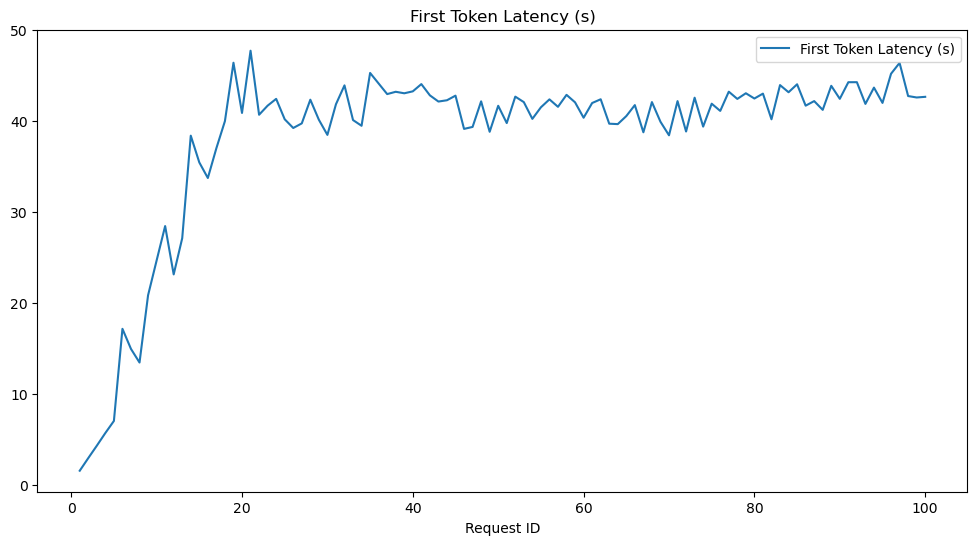

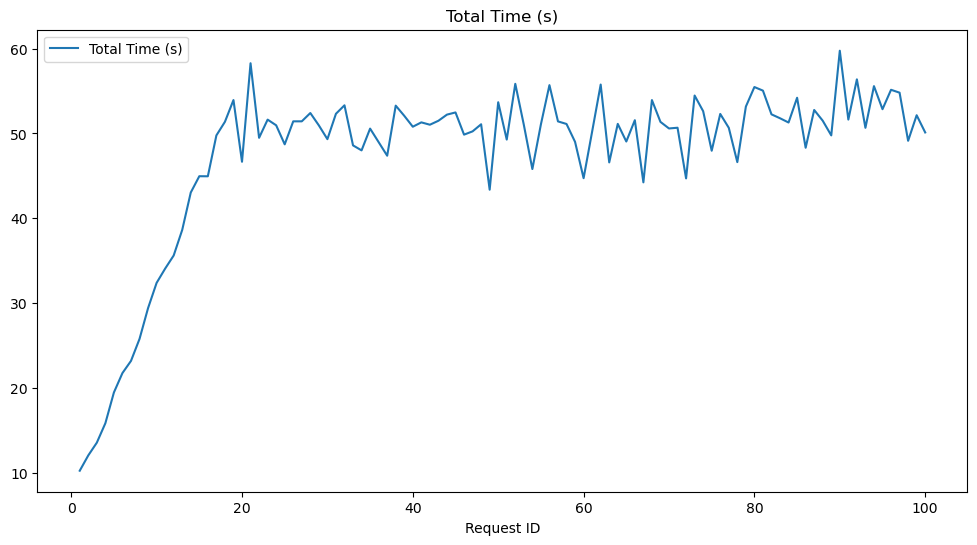

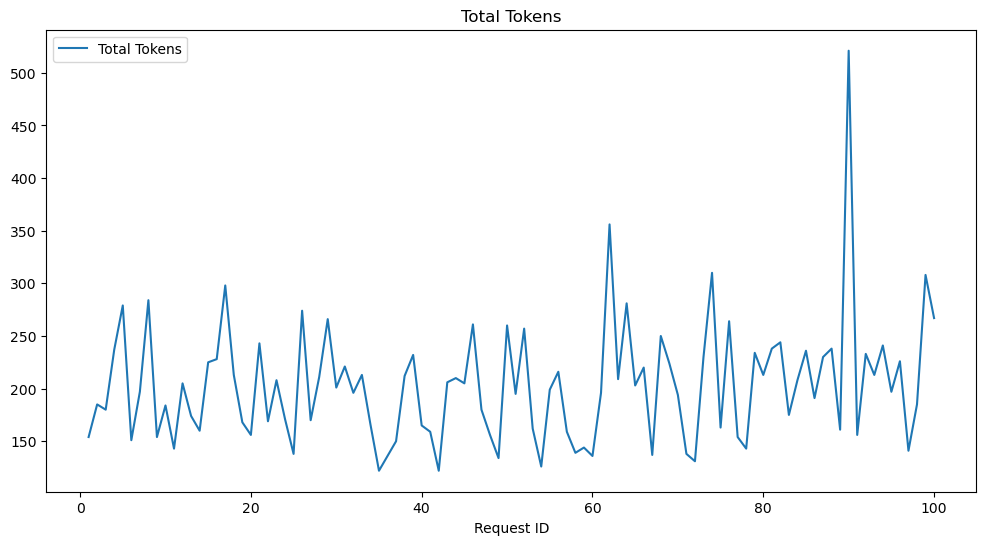

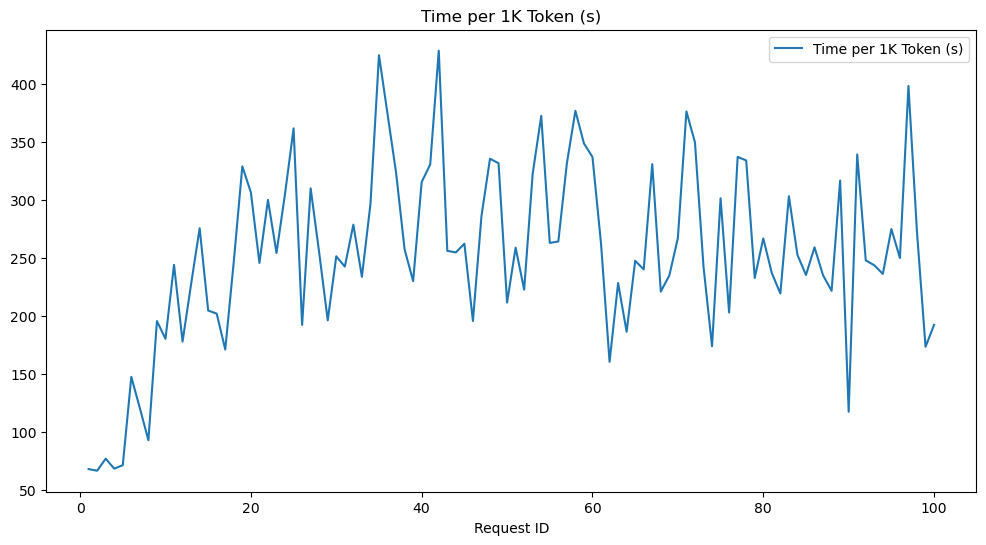

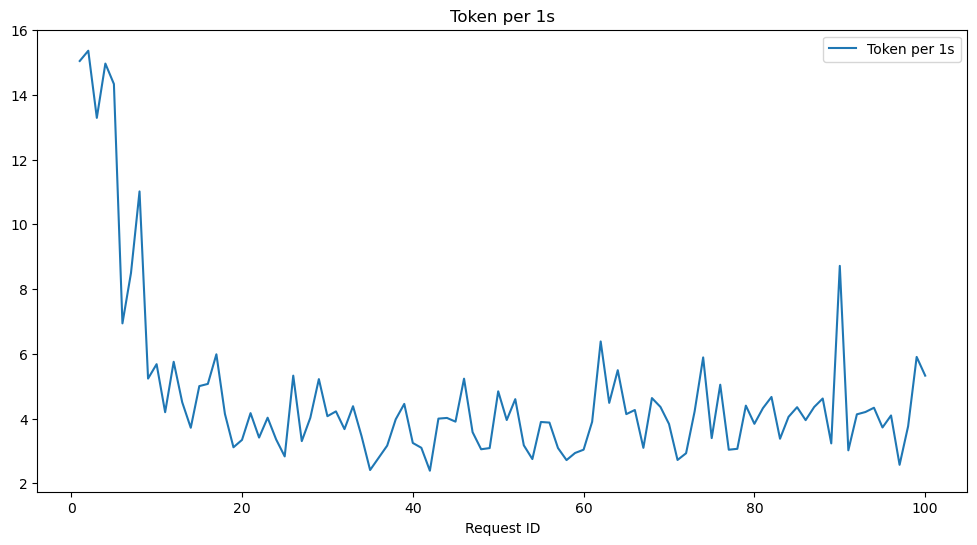

In [183]:
import concurrent.futures
import pandas as pd
    
def submit_concurrent_requests(num_requests, prompts):
    # 存储指标数据
    request_ids = []
    first_token_latencies = []
    total_times = []
    total_tokens = []
    time_per_1k_tokens = []
    tokens_per_second = []
    prompts_list = [prompts] * num_requests
    total_failure = 0
    
    #并发20是单G5.2xlarge的极限（100请求出现1个失败），如果prompt的token数量减少(目前输入输出一共约3000)，可以支持到24
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(res_gen_stream, prompts) for prompt in prompts_list]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
        #return results

        for i, result in enumerate(results, start=1):
            if result:
                first_token_latency, res_time, token_len = result
                print(f"Request {i}:")
                print(f"First Token Latency: {first_token_latency:.2f} seconds")
                print(f"Total Time: {res_time:.2f} seconds")
                print(f"Total Tokens: {token_len}")
                print(f"Time per 1K Token: {res_time*1024/token_len} seconds")
                print(f"Token per 1s: {token_len/res_time} tokens")
        
                # 存储指标数据
                request_ids.append(i)
                first_token_latencies.append(first_token_latency)
                total_times.append(res_time)
                total_tokens.append(token_len)
                time_per_1k_tokens.append(res_time*1024/token_len)
                tokens_per_second.append(token_len/res_time)
                
            else:
                print(f"Request {i} failed.")
                total_failure += 1
            print("-" * 50)
    print(f"Total failure: {total_failure}")
    # 创建 DataFrame
    data = {
        'Request ID': request_ids,
        'First Token Latency (s)': first_token_latencies,
        'Total Time (s)': total_times,
        'Total Tokens': total_tokens,
        'Time per 1K Token (s)': time_per_1k_tokens,
        'Token per 1s': tokens_per_second
    }
    df = pd.DataFrame(data)

     # 将 DataFrame 写入 CSV 文件
    #df.to_csv('qwen25-concurrent-test-result/metrics.csv', index=False)

    # 创建折线图
    for column in df.columns[1:]:
        chart = pd.DataFrame({
            'Request ID': df['Request ID'],
            column: df[column]
        }).set_index('Request ID').plot(kind='line', title=column, figsize=(12, 6))
        #chart.figure.savefig(f'qwen25-concurrent-test-result/{column}.png')
    
    
# 示例用法
num_requests = 100
submit_concurrent_requests(num_requests, prompts)




## qwen15+HF框架与qwen25+vllm的性能对比结果

1. 测试目标
    
    通过同样token数的问题验证在相同的A10单卡上通过2.5版本以及vllm实现的性能提升
    
2. 测试用例
    
    约2700个输入token的背景prompt包含相同的问题，提交10次作业，对比每秒产生的token数变化以及1K token产生的用时。模型采用int8和int4两种GPTQ量化技术
    
3. 测试发现
   
   a.切换为vllm后由于模型中已经实现了相应的get model和inference方法，无需使用自定义的model.py文件
    
   b.中国区不推荐使用0.30的djl-lmi的镜像，部署时会出现异常
    
   c.测试具体结果如下
   
        
    Qwen2.5(INT8)+vllm
        
        avg Token: 228.9
        avg Time per 1K Token: 17.00462971258601
        avg Token per 1s: 60.218894342761516
        
    Qwen2.5(INT4)+vllm
        
        avg Token: 211.4
        avg Time per 1K Token: 17.20364607970672
        avg Token per 1s: 60.218894342761516
        
    Qwen1.5+HF     
    
        avg Token: 666.0
        avg Time per 1K Token: 37.71944202503285
        avg Token per 1s: 27.147803494028707
        
4. 测试结论

    a.Qwen2.5+VLLM相比Qwen1.5+HF框架在A10显卡可以提升一倍的性能
    
    b.Qwen2.5生成答案内容更加简洁，平均在200 token左右，但1.5生成600个token答案
    
    c.Int8相比Int4没有对性能带来提升
    
    

## 删除资源

In [192]:
!aws sagemaker delete-endpoint --endpoint-name {endpoint_name}

In [193]:
!aws sagemaker delete-endpoint-config --endpoint-config-name {endpoint_config_name}

In [194]:
!aws sagemaker delete-model --model-name {model_name}